In [1]:
import torch
import torch.nn as nn
import numpy as np

from datasets.openml_datasets import OpenML_Dataset
from datasets.torch_datasets import Torch_Dataset
from utils.weakener import Weakener
from models.model import MLP
from utils.losses import PartialLoss,CELoss
from utils.trainig_testing import train_and_evaluate,warm_up

In this case we will create 4 data structures so they contain the 4 Weak structures that support the 4 reconstruction matrices

In [2]:
rec_names = ['_pinv', '_opt', '_conv', '_optconv']
batch_size = 16
dataset_objects = []
weakener_objects = []

# Create dataset objects
for name in rec_names:
    dataset_name = 'Data' + name
    dataset = Torch_Dataset('mnist', batch_size=batch_size)
    dataset_objects.append(dataset)
    globals()[dataset_name] = dataset  # store dataset object in a variable with the corresponding name

# Create weakener objects
for name in rec_names:
    dataset_name = 'Data' + name
    weakener_name = 'Weak' + name
    weakener = Weakener(globals()[dataset_name].num_classes)
    weakener_objects.append(weakener)
    globals()[weakener_name] = weakener

In [3]:
rec_params = {'_pinv':{'optimize':False,'convex':False},
              '_opt':{'optimize':True,'convex':False},
              '_conv':{'optimize':False,'convex':True},
              '_optconv':{'optimize':True,'convex':True}}
for i,name in enumerate(rec_names):
    weakener_objects[i].generate_M('pll')
    _,train_y,_,_ =  globals()['Data'+name].get_data()
    #_,train_y,_,_ =  dataset_objects[i].get_data()
    _,_ = globals()['Weak'+name].generate_weak(train_y)
    #_,_ = weakener_objects[i].generate_weak(train_y)
    globals()['Weak'+name].virtual_matrix(convex=rec_params[name]['convex'],
                                       optimize=rec_params[name]['optimize'])
    #weakener_objects[i].virtual_matrix(convex=rec_params[name]['convex'],
    #                                   optimize=rec_params[name]['optimize'])
    globals()['Weak'+name].virtual_labels()
    #weakener_objects[i].virtual_labels()
    globals()['Data'+name].include_weak(globals()['Weak'+name].v)
    #dataset_objects[i].include_weak(weakener_objects[i].v)

In [4]:
#We will do the trainig for all the models
all_result = {}
all_model = {}
for i,name in enumerate(rec_names):
    trainloader, testloader = globals()['Data'+name].get_dataloader()
    mlp = MLP(globals()['Data'+name].num_features,[globals()['Data'+name].num_features],
              globals()['Data'+name].num_classes,dropout_p = 0.5, bn = True)
    optim = torch.optim.Adam(mlp.parameters(),lr=1e-2)
    loss = CELoss()
    print('\nTraining for'+ name +'reconstruction starts:\n')
    mlp, results = train_and_evaluate(mlp,trainloader,testloader,
                                      optimizer=optim,loss_fn=loss,num_epochs=10)
    all_model[name] = {'model':mlp,'optimizer':optim,'loss':loss}
    all_result[name] = results


Training for_pinvreconstruction starts:


Epoch 1/10: Train Loss: 2.3381, Train Acc: 0.7177, Test Acc: 0.8816
Epoch 2/10: Train Loss: 0.5519, Train Acc: 0.7685, Test Acc: 0.8818
Epoch 3/10: Train Loss: -6.3364, Train Acc: 0.7861, Test Acc: 0.9131
Epoch 4/10: Train Loss: -23.7376, Train Acc: 0.8013, Test Acc: 0.8999
Epoch 5/10: Train Loss: -62.4471, Train Acc: 0.8029, Test Acc: 0.8970
Epoch 6/10: Train Loss: -141.6336, Train Acc: 0.8094, Test Acc: 0.9006
Epoch 7/10: Train Loss: -263.2819, Train Acc: 0.8101, Test Acc: 0.8902
Epoch 8/10: Train Loss: -475.9227, Train Acc: 0.8092, Test Acc: 0.8938
Epoch 9/10: Train Loss: -755.5304, Train Acc: 0.8072, Test Acc: 0.8949
Epoch 10/10: Train Loss: -1171.0964, Train Acc: 0.8032, Test Acc: 0.8932
Training for_optreconstruction starts:


Epoch 1/10: Train Loss: 1.9680, Train Acc: 0.7185, Test Acc: 0.8364
Epoch 2/10: Train Loss: 0.8479, Train Acc: 0.7559, Test Acc: 0.8805
Epoch 3/10: Train Loss: -1.0386, Train Acc: 0.7733, Test Acc: 0.9076
Epoch 4/10

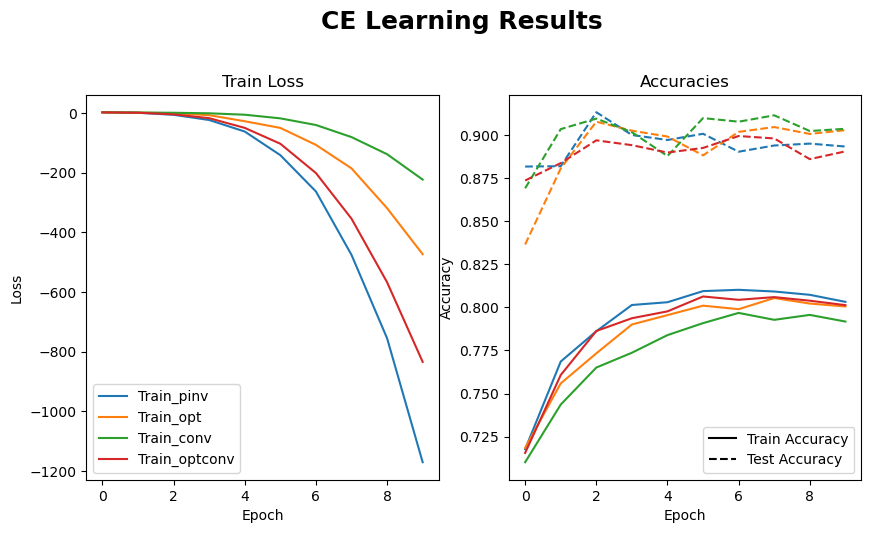

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

tableau_palette = mcolors.TABLEAU_COLORS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
colors = list(tableau_palette.values())

# Plot the first subplot (Train Loss)
for i,name in enumerate(rec_names):
    ax1.plot(all_result[name]['train_loss'],label='Train'+name,color=colors[i])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Train Loss')


# Plot the second subplot (Accuracies)
for i,name in enumerate(rec_names):
    ax2.plot(all_result[name]['train_acc'], label='Train Accuracy'+name,
             color=colors[i])
    ax2.plot(all_result[name]['test_acc'], label='Test Accuracy'+name,
             color=colors[i],linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracies')
#ax2.legend()
legend_elements = [Line2D([0], [0], linestyle='-', color='black', label='Train Accuracy'),
                   Line2D([0], [0], linestyle='--', color='black', label='Test Accuracy')]
ax2.legend(handles=legend_elements)

fig.suptitle('CE Learning Results', fontsize=18, fontweight='bold', y=1.05)
# Show the plot
plt.show()